In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import prince
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, roc_curve, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import seaborn as sns
from itertools import product
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from statistics import mean
import tensorflow as tf
import shap
%matplotlib inline
from xgboost import XGBClassifier

/home/joel/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:59: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


In [2]:
plt.style.use("seaborn")

## Import the data

In [3]:
IND_a= pd.read_csv("../Datasets/South Africa_2021_access.csv")
IND_u= pd.read_csv('../Datasets/South Africa_2021_usage.csv')
y= IND_a['fin34a'].copy()
w= IND_a['wgt'].copy()
IND_a= IND_a.drop(columns=['wgt','fin34a'])
IND_u= IND_u.drop(columns=['wgt','fin34a'])

In [4]:
y.value_counts(normalize=True)

0    0.587771
1    0.412229
Name: fin34a, dtype: float64

In [5]:
sup= IND_a[IND_a.columns[:4]]
sup

,female,age,educ,inc_q
0,2,2.0,2,4
1,1,2.0,2,5
2,1,2.0,2,3
3,1,6.0,2,5
4,1,3.0,3,5
...,...,...,...,...
1009,2,2.0,2,4
1010,1,2.0,2,4
1011,2,1.0,2,2
1012,1,1.0,2,5


In [6]:
contingency_table = pd.crosstab(IND_a['educ'], IND_a['inc_q'])
contingency_table

inc_q,1,2,3,4,5
educ,,,,,
1,28,29,20,13,10
2,144,123,146,160,198
3,11,4,13,22,93


In [7]:
IND_a= IND_a.drop(columns= IND_a.columns[:4])
IND_u= IND_u.drop(columns= IND_u.columns[:4])

## Implementing MCA

In [8]:
mca_a = prince.MCA(n_components=9)

# Fit the MCA model to your data
mca_a.fit(IND_a)

# Transform the data into MCA coordinates
IND_a_index = mca_a.transform(IND_a)
new_column_names_a = {i: f'aPC{i+1}' for i in IND_a_index.columns}
IND_a_index = IND_a_index.rename(columns=new_column_names_a)
IND_a_index

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,aPC7,aPC8,aPC9
0,1.074188,-1.351659,-0.185874,0.299246,-0.156746,0.488387,-0.434731,-0.292251,-0.035563
1,-0.326648,-0.335021,0.389187,-0.346204,0.434136,-0.505139,0.307367,0.023105,-0.032295
2,-0.130998,0.320321,0.097826,0.165809,-0.188256,-0.071784,-0.829741,-0.248170,0.504697
3,0.781935,0.295307,-0.252219,-0.003071,-0.093611,-0.619032,-0.270318,0.593035,0.568825
4,-0.537068,-0.543834,0.564285,-0.030861,0.370754,-0.230920,-0.117783,0.023998,-0.033145
...,...,...,...,...,...,...,...,...,...
1009,1.782591,-0.366214,-0.318351,-0.158557,-0.066210,-0.460749,-0.490071,-0.259729,-0.074636
1010,-0.469945,-0.173075,0.170214,-0.067968,-0.321001,0.206865,-0.137695,-0.102089,-0.008860
1011,0.088694,0.044697,-0.574955,-0.199197,0.201075,0.267516,0.160245,0.487019,-0.084283
1012,-0.239240,0.207566,-0.461341,-0.387178,0.297288,0.255585,0.127850,-0.057209,-0.008611


In [9]:
mca_u = prince.MCA(n_components=32)

# Fit the MCA model to your data
mca_u.fit(IND_u)

# Transform the data into MCA coordinates
IND_u_index = mca_u.transform(IND_u)
new_column_names_u = {i: f'uPC{i+1}' for i in IND_u_index.columns}
IND_u_index = IND_u_index.rename(columns=new_column_names_u)
IND_u_index

,uPC1,uPC2,uPC3,uPC4,uPC5,uPC6,uPC7,uPC8,uPC9,uPC10,...,uPC23,uPC24,uPC25,uPC26,uPC27,uPC28,uPC29,uPC30,uPC31,uPC32
0,-0.345006,-0.228150,0.058990,-0.193057,0.128533,-0.089442,0.114893,-0.357350,0.195416,-0.117606,...,-0.082848,0.013724,-0.131997,0.017282,0.056359,0.034999,0.122250,0.078896,-0.000478,-0.074406
1,0.290457,0.093085,-0.448423,-0.300595,-0.016554,-0.301343,-0.031951,0.167533,-0.282844,0.294273,...,-0.206661,0.158311,0.211476,-0.017161,-0.123583,-0.063665,0.076298,-0.068252,0.044341,-0.004632
2,0.427954,0.029782,-0.073163,0.297516,-0.038594,0.557054,-0.231070,-0.068929,0.031717,-0.138123,...,0.278383,0.182624,0.008505,-0.178973,0.031338,0.002231,0.074682,0.089385,0.132490,0.101837
3,-0.454585,0.435626,-0.480129,-0.292335,0.372654,-0.235779,0.399332,-0.036269,-0.046867,-0.058466,...,-0.093507,-0.024951,-0.010341,-0.012622,-0.059868,0.027609,0.109901,0.058467,-0.016295,-0.061468
4,0.959459,-0.151721,-0.136310,0.019127,-0.107259,-0.030692,0.083897,-0.309633,-0.127756,0.285990,...,0.087321,0.075962,0.021506,-0.008459,0.011660,-0.027434,0.034019,0.022385,-0.049802,0.023339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,-0.663087,-0.292459,-0.079445,-0.306662,0.063619,0.087793,0.182558,-0.134055,0.046835,-0.000412,...,0.036115,-0.004425,-0.009220,-0.030089,0.004558,-0.029406,-0.025159,-0.017196,-0.032068,0.025441
1010,0.681238,0.045443,0.112981,-0.041215,-0.280975,0.273895,0.125947,-0.094073,-0.013632,-0.016324,...,0.021558,0.086711,-0.129300,-0.031864,0.021617,-0.035991,-0.007527,0.009341,-0.016717,0.004262
1011,0.019613,-0.341083,0.101685,0.200314,0.085228,-0.123640,-0.093685,-0.250190,-0.002347,0.142403,...,-0.158605,-0.050501,0.115024,0.130506,-0.001997,0.029072,0.020052,0.001186,0.022077,0.005091
1012,-0.182896,-0.292371,0.206163,-0.113636,0.137693,-0.029600,-0.243784,0.024223,-0.006757,0.052246,...,-0.136301,0.120164,0.144820,-0.026114,0.002653,0.035078,-0.065203,0.006370,-0.004452,-0.017398


In [10]:
X = pd.concat([IND_a_index, IND_u_index, sup], axis=1)
X

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,aPC7,aPC8,aPC9,uPC1,...,uPC27,uPC28,uPC29,uPC30,uPC31,uPC32,female,age,educ,inc_q
0,1.074188,-1.351659,-0.185874,0.299246,-0.156746,0.488387,-0.434731,-0.292251,-0.035563,-0.345006,...,0.056359,0.034999,0.122250,0.078896,-0.000478,-0.074406,2,2.0,2,4
1,-0.326648,-0.335021,0.389187,-0.346204,0.434136,-0.505139,0.307367,0.023105,-0.032295,0.290457,...,-0.123583,-0.063665,0.076298,-0.068252,0.044341,-0.004632,1,2.0,2,5
2,-0.130998,0.320321,0.097826,0.165809,-0.188256,-0.071784,-0.829741,-0.248170,0.504697,0.427954,...,0.031338,0.002231,0.074682,0.089385,0.132490,0.101837,1,2.0,2,3
3,0.781935,0.295307,-0.252219,-0.003071,-0.093611,-0.619032,-0.270318,0.593035,0.568825,-0.454585,...,-0.059868,0.027609,0.109901,0.058467,-0.016295,-0.061468,1,6.0,2,5
4,-0.537068,-0.543834,0.564285,-0.030861,0.370754,-0.230920,-0.117783,0.023998,-0.033145,0.959459,...,0.011660,-0.027434,0.034019,0.022385,-0.049802,0.023339,1,3.0,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,1.782591,-0.366214,-0.318351,-0.158557,-0.066210,-0.460749,-0.490071,-0.259729,-0.074636,-0.663087,...,0.004558,-0.029406,-0.025159,-0.017196,-0.032068,0.025441,2,2.0,2,4
1010,-0.469945,-0.173075,0.170214,-0.067968,-0.321001,0.206865,-0.137695,-0.102089,-0.008860,0.681238,...,0.021617,-0.035991,-0.007527,0.009341,-0.016717,0.004262,1,2.0,2,4
1011,0.088694,0.044697,-0.574955,-0.199197,0.201075,0.267516,0.160245,0.487019,-0.084283,0.019613,...,-0.001997,0.029072,0.020052,0.001186,0.022077,0.005091,2,1.0,2,2
1012,-0.239240,0.207566,-0.461341,-0.387178,0.297288,0.255585,0.127850,-0.057209,-0.008611,-0.182896,...,0.002653,0.035078,-0.065203,0.006370,-0.004452,-0.017398,1,1.0,2,5


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 64)

## Logistic regression

In [12]:
lr = LogisticRegression(solver='newton-cg', max_iter=200)

#Setting the range for class weights
weights= [.01* i for i in range(1, 101)]
weights= list(product(weights, weights))

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0: .77, 1:.95}], 
              'C': [i for i in range(1,2)]}

#Fitting grid search to the train data with 5 folds
grid_search_lr = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [13]:
print('Best parameters:', grid_search_lr.best_params_)
print('Best score:', grid_search_lr.best_score_)

Best parameters: {'C': 1, 'class_weight': {0: 0.77, 1: 0.95}}
Best score: 0.9511125796719828


In [14]:
best_lr = LogisticRegression(**grid_search_lr.best_params_)
best_lr.fit(X_train, y_train)

proba = best_lr.predict_proba(X_test)
y_= proba[:,1]

auc1 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc1)

# Calculate precision, recall, and F1-score
target_names = ["0", "1"]
treshold= 0.5
y_pred = (y_ >= treshold).astype(int)
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9862412761714855
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       118
           1       0.94      0.98      0.96        85

    accuracy                           0.97       203
   macro avg       0.96      0.97      0.96       203
weighted avg       0.97      0.97      0.97       203



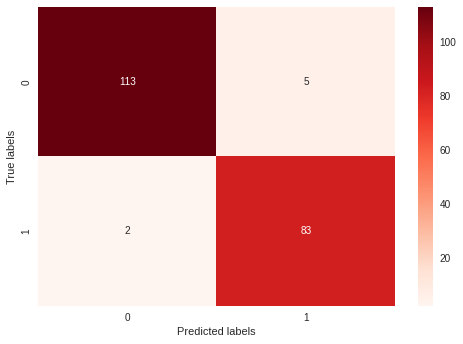

In [15]:
cm1 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [16]:
acc_1= accuracy_score(y_test, y_pred)
pre_1= precision_score(y_test, y_pred)
rec_1= recall_score(y_test, y_pred)
f_1_1= f1_score(y_test, y_pred)

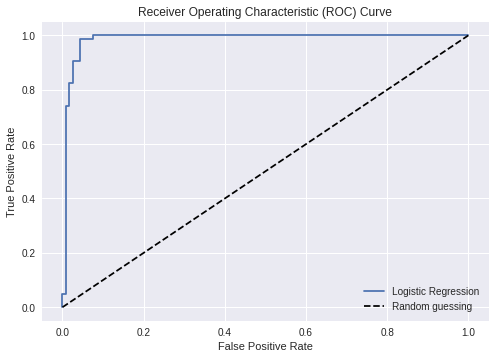

In [17]:
fpr1, tpr1, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Random Forest

In [18]:
weights= [.01* i for i in range(1, 101)]
weights= list(product(weights, weights))
param_grid = {
    'n_estimators': [87],
    'max_depth': [7],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'max_features': ['sqrt'],
    'class_weight': [{0: .06, 1: .11}]
}
rf = RandomForestClassifier(random_state= 42)

In [19]:
grid_search_rf = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
best_rf = RandomForestClassifier(**grid_search_rf.best_params_)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
proba= best_rf.predict_proba(X_test)
y_=proba[:,1]
print(f'Best hyperparameters: {grid_search_rf.best_params_}')
print('Best score:', grid_search_rf.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'class_weight': {0: 0.06, 1: 0.11}, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 87}
Best score: 0.8962531613334541


In [20]:
auc2 = roc_auc_score(y_test, proba[:,1], multi_class='auto')
print('AUC:', auc2)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9574277168494516
              precision    recall  f1-score   support

           0       0.91      0.88      0.90       118
           1       0.84      0.88      0.86        85

    accuracy                           0.88       203
   macro avg       0.88      0.88      0.88       203
weighted avg       0.88      0.88      0.88       203



In [21]:
acc_2= accuracy_score(y_test, y_pred)
pre_2= precision_score(y_test, y_pred)
rec_2= recall_score(y_test, y_pred)
f_1_2= f1_score(y_test, y_pred)

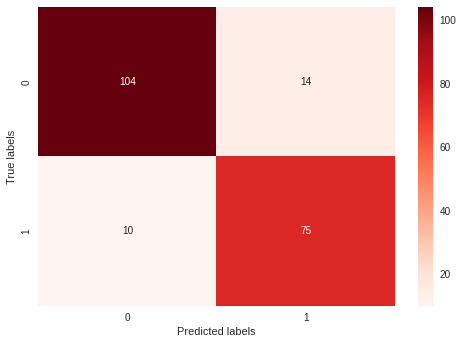

In [22]:
cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

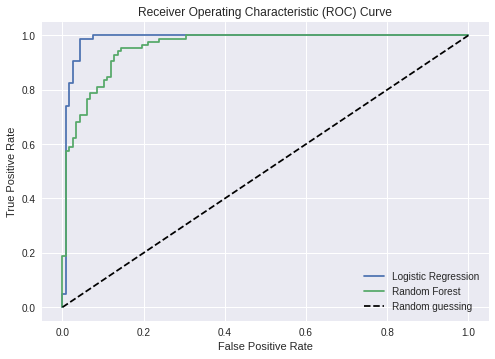

In [23]:
fpr2, tpr2, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## XG Boost

In [24]:
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
scale_pos_weight = neg / pos

In [25]:
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight)
param_grid = {
    'max_depth': [10],
    'learning_rate': [.1],
    'n_estimators': [376],
    'subsample': [0.5],
    'colsample_bytree': [0.5],
    'reg_alpha': [0.5],
    'reg_lambda': [0.1],
}
grid_search_xgb = GridSearchCV(estimator=xgb, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
print("Best hyperparameters: ", grid_search_xgb.best_params_)
print("Best F1 score: ", grid_search_xgb.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 376, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.5}
Best F1 score:  0.9504694852556369


In [26]:
best_xgb = XGBClassifier(**grid_search_xgb.best_params_)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
proba = best_xgb.predict_proba(X_test)
y_= proba[:,1]

In [27]:
auc3 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc3)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9792622133599203
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       118
           1       0.91      0.96      0.94        85

    accuracy                           0.95       203
   macro avg       0.94      0.95      0.94       203
weighted avg       0.95      0.95      0.95       203



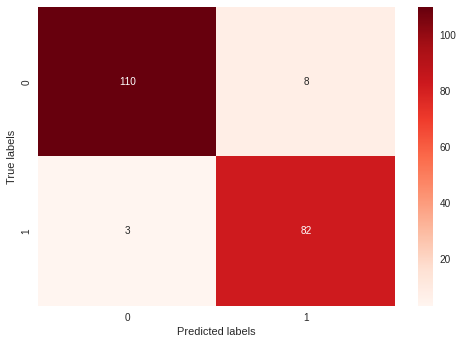

In [28]:
cm3 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm3, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [29]:
acc_3= accuracy_score(y_test, y_pred)
pre_3= precision_score(y_test, y_pred)
rec_3= recall_score(y_test, y_pred)
f_1_3= f1_score(y_test, y_pred)

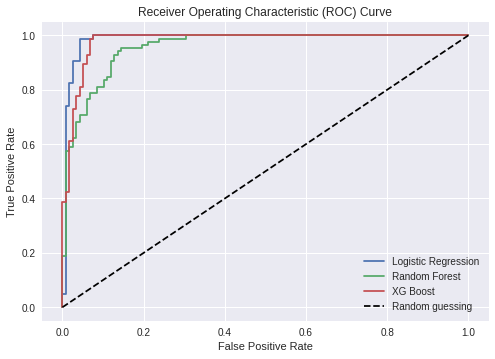

In [30]:
fpr3, tpr3, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot(fpr3, tpr3, label='XG Boost')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Artificial Neural Network

In [31]:
ann = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [32]:
ann.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [33]:
history = ann.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/50
21/21 [==============================] - 1s 9ms/step - loss: 0.6313 - precision: 0.6387 - recall: 0.3822 - val_loss: 0.5757 - val_precision: 0.6593 - val_recall: 0.8108
Epoch 2/50
21/21 [==============================] - 0s 2ms/step - loss: 0.5225 - precision: 0.6756 - recall: 0.6834 - val_loss: 0.5017 - val_precision: 0.7647 - val_recall: 0.7027
Epoch 3/50
21/21 [==============================] - 0s 2ms/step - loss: 0.4501 - precision: 0.7570 - recall: 0.7336 - val_loss: 0.4336 - val_precision: 0.7971 - val_recall: 0.7432
Epoch 4/50
21/21 [==============================] - 0s 2ms/step - loss: 0.4001 - precision: 0.7555 - recall: 0.7992 - val_loss: 0.3834 - val_precision: 0.8382 - val_recall: 0.7703
Epoch 5/50
21/21 [==============================] - 0s 2ms/step - loss: 0.3459 - precision: 0.8347 - recall: 0.7992 - val_loss: 0.3286 - val_precision: 0.8649 - val_recall: 0.8649
Epoch 6/50
21/21 [==============================] - 0s 2ms/step - loss: 0.3027 - precision: 0.8315 -

In [34]:
y_ = ann.predict(X_test)

7/7 [==============================] - 0s 680us/step


In [35]:
y_= y_.reshape(y_.shape[0],)

In [36]:
y_pred= np.array([round(i) for i in y_])

In [37]:
auc4 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc4)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9897308075772682
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       118
           1       0.95      0.92      0.93        85

    accuracy                           0.95       203
   macro avg       0.95      0.94      0.94       203
weighted avg       0.95      0.95      0.95       203



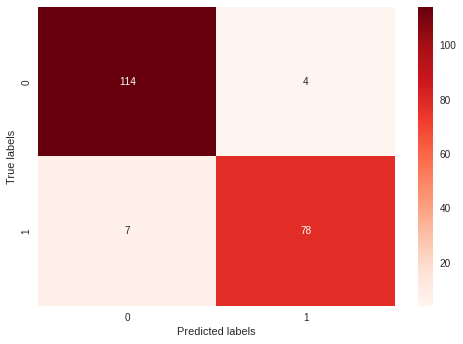

In [38]:
cm4 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm4, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [39]:
acc_4= accuracy_score(y_test, y_pred)
pre_4= precision_score(y_test, y_pred)
rec_4= recall_score(y_test, y_pred)
f_1_4= f1_score(y_test, y_pred)

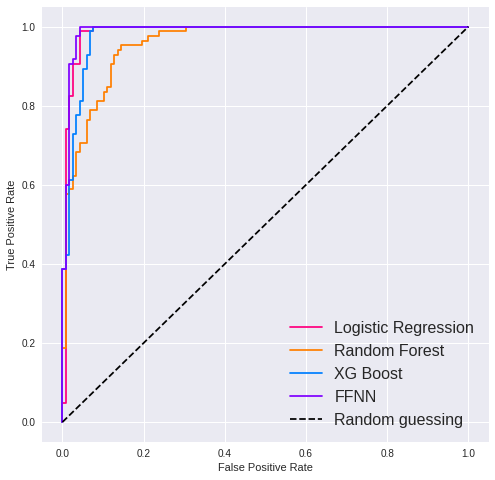

In [67]:
fpr4, tpr4, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr1, tpr1, label='Logistic Regression', color= "#ff007f")
plt.plot(fpr2, tpr2, label='Random Forest', color= "#ff7f00")
plt.plot(fpr3, tpr3, label='XG Boost', color= "#007fff")
plt.plot(fpr4, tpr4, label='FFNN', color= "#7f00ff")
plt.plot([0, 1], [0, 1], linestyle='--', color= "#000000", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(fontsize=16)
plt.savefig("../../images/roc_sa.png")
plt.show()

## Model Evaluations

In [41]:
data= {"Metrics":["Accuracy", "Recall", "Precision", "F1-Score", "AUC"],
       "LR":[round(acc_1,4), round(rec_1,4), round(pre_1,4), round(f_1_1,4), round(auc1,4)], 
       "RF":[round(acc_2,4), round(rec_2,4), round(pre_2,4), round(f_1_2,4), round(auc2,4)], 
       "XGB":[round(acc_3,4), round(rec_3,4), round(pre_3,4), round(f_1_3,4), round(auc3,4)], 
       "FFNN":[round(acc_4,4), round(rec_4,4), round(pre_4,4), round(f_1_4,4), round(auc4,4)]}
df = pd.DataFrame(data)
latex_code = df.to_latex(index=False)

# Print the LaTeX code
print(latex_code)

\begin{tabular}{lrrrr}
\toprule
  Metrics &     LR &     RF &    XGB &   FFNN \\
\midrule
 Accuracy & 0.9655 & 0.8818 & 0.9458 & 0.9458 \\
   Recall & 0.9765 & 0.8824 & 0.9647 & 0.9176 \\
Precision & 0.9432 & 0.8427 & 0.9111 & 0.9512 \\
 F1-Score & 0.9595 & 0.8621 & 0.9371 & 0.9341 \\
      AUC & 0.9862 & 0.9574 & 0.9793 & 0.9897 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Build the index

In [42]:
eig_a= mca_a.eigenvalues_
IND_a_index["access"]= sum([IND_a_index[IND_a_index.columns[i]]*eig_a[i] for i in range(len(eig_a))])
eig_u= mca_u.eigenvalues_
IND_u_index["usage"]= sum([IND_u_index[IND_u_index.columns[i]]*eig_u[i] for i in range(len(eig_u)) ])

In [43]:
IND_fin= pd.concat([IND_a_index["access"], IND_u_index["usage"], sup, y], axis=1)

In [44]:
IND_fin["access"]= IND_fin["access"]*w
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(-0.8736178440387846, 4.813582639435424, 0.07723557243166765)

In [45]:
IND_fin["access"] -= min(IND_fin["access"])
IND_fin["access"] /= max(IND_fin["access"])

In [46]:
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(0.0, 1.0, 0.1671918229774789)

In [47]:
IND_fin["usage"]= IND_fin["usage"]*w
min(IND_fin["usage"]), max(IND_fin["usage"]), mean(IND_fin["usage"])

(-0.6592854031178278, 0.6141896314214668, -0.014640063595571592)

In [48]:
IND_fin["usage"] -= min(IND_fin["usage"])
IND_fin["usage"] /= max(IND_fin["usage"])

In [49]:
IND_fin["access"] = 1- IND_fin["access"]
#IND_fin["usage"] = 1- IND_fin["usage"]

In [50]:
IND_fin["index"]= (IND_fin['access'] + IND_fin['usage'])/2

In [51]:
fin_0= IND_fin[IND_fin["fin34a"]==0].copy()
fin_1= IND_fin[IND_fin["fin34a"]==1].copy()

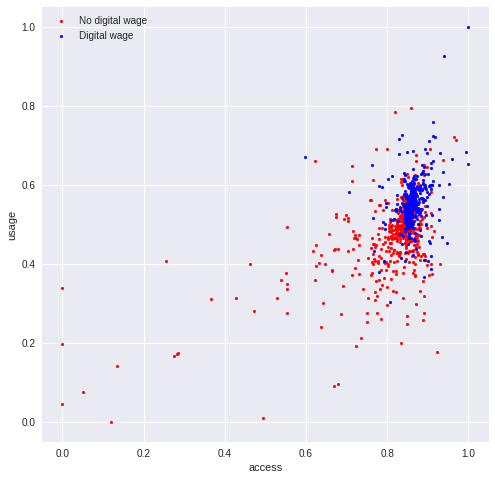

In [52]:
m1_a= mean(fin_1["access"])
m1_u= mean(fin_1["usage"])
m0_a= mean(fin_0["access"])
m0_u= mean(fin_0["usage"])
plt.figure(figsize=(8,8))
plt.scatter(fin_0["access"], fin_0["usage"], label= "No digital wage", s=32, color="#ff0000",
            marker='.')
plt.scatter(fin_1["access"], fin_1["usage"], label= "Digital wage", s=32, color='#0000ff' , #"#87CEEB",
            marker='.')
plt.xlabel("access")
plt.ylabel("usage")
plt.legend()
#plt.xlim([0.95,1.05])
#plt.ylim([0.65,1.05])
plt.savefig('../../images/find_sa')
plt.show()

In [53]:
IND_fin['access'].describe()

count    1014.000000
mean        0.832808
std         0.092514
min         0.000000
25%         0.833087
50%         0.852270
75%         0.863933
max         1.000000
Name: access, dtype: float64

In [54]:
IND_fin['usage'].describe()

count    1014.000000
mean        0.506210
std         0.090575
min         0.000000
25%         0.473858
50%         0.517241
75%         0.550568
max         1.000000
Name: usage, dtype: float64

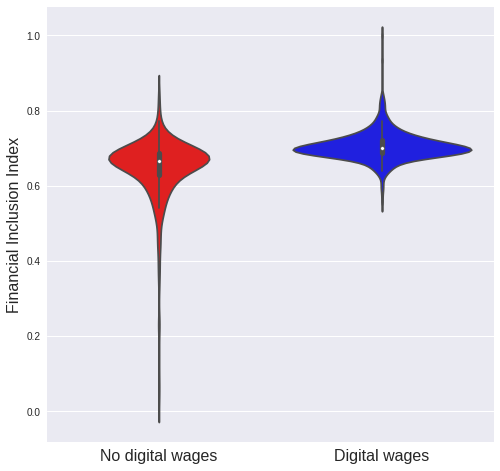

In [71]:
colors = ["#ff0000", "#0000ff"]
plt.figure(figsize=(8, 8))
sns.violinplot(x='fin34a', y='index', data=IND_fin, palette= colors)
custom_category_names = ['No digital wages', 'Digital wages']
plt.xticks(range(len(custom_category_names)), custom_category_names, fontsize=16)
plt.xlabel('')
plt.ylabel('Financial Inclusion Index', fontsize=16)
#plt.title('Labeled Violin Plot with Custom Category Names')
plt.savefig('../../images/ind_sa')
# Show the plot
plt.show()


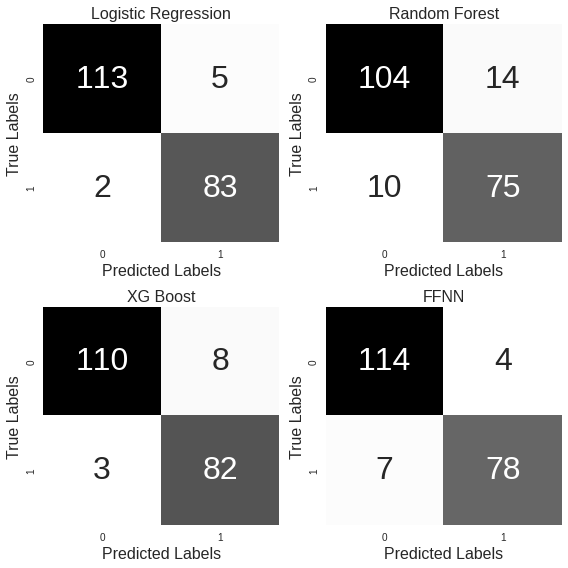

In [68]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
cm= [cm1, cm2, cm3, cm4]
mods= ["Logistic Regression", "Random Forest", "XG Boost", "FFNN"]
# Compute and plot confusion matrices
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(cm[i], annot=True, cbar=False, cmap="Greys", fmt='d', ax=ax, 
                annot_kws={"fontsize": 32})
    ax.set_title(f"{mods[i]}", fontsize=16)
    ax.set_xlabel("Predicted Labels", fontsize=16)
    ax.set_ylabel("True Labels", fontsize=16)

# Adjust subplot spacing
plt.tight_layout()
plt.savefig('../../images/comat_sa.png')
# Display the plot
plt.show()

## Feature Importance

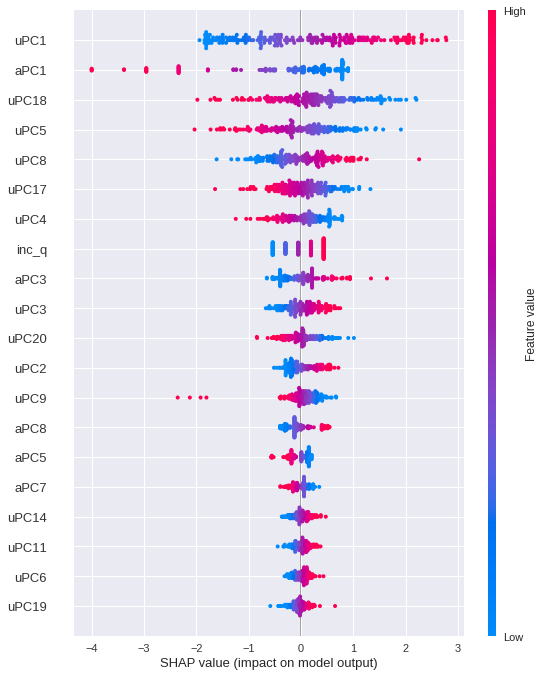

In [57]:
explainer = shap.Explainer(best_lr, X_train)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
fig, ax = plt.subplots()
shap.summary_plot(shap_values, X_test)
plt.show()

In [58]:
u= mca_u.column_contributions_
u= u.rename(columns=new_column_names_u)
a= mca_a.column_contributions_
a= a.rename(columns=new_column_names_a)

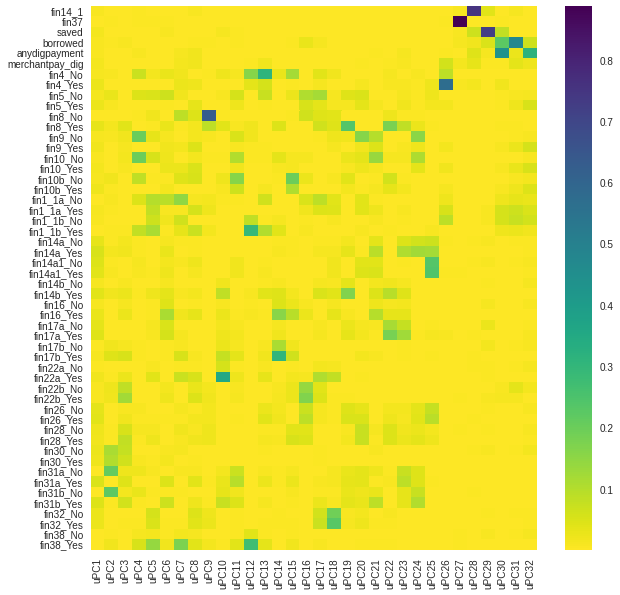

In [59]:
plt.figure(figsize=(10,10))
sns.heatmap(u, annot=False, cmap="viridis_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.show()

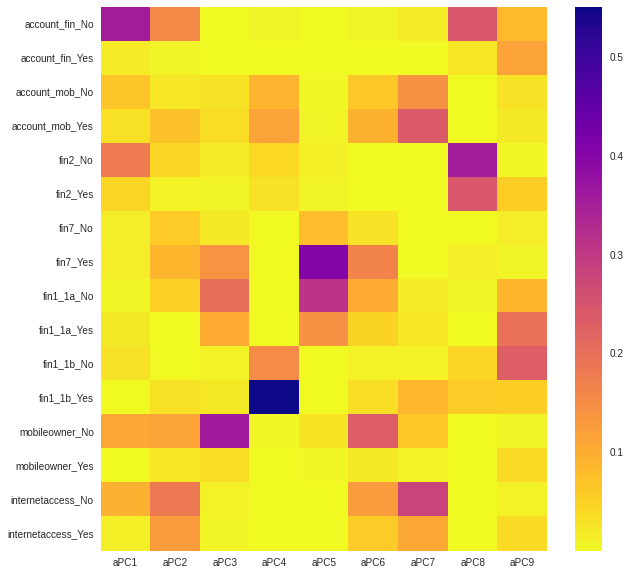

In [60]:
plt.figure(figsize=(10,10))
sns.heatmap(a, annot=False, cmap="plasma_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.show()

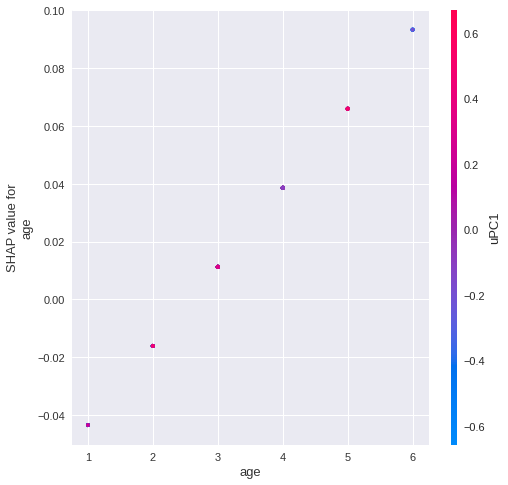

In [61]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('age', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

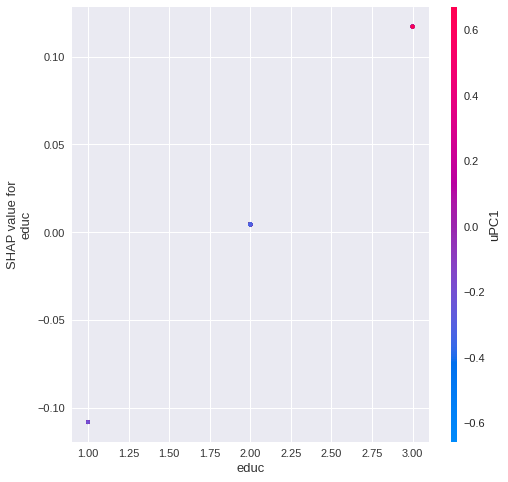

In [62]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('educ', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

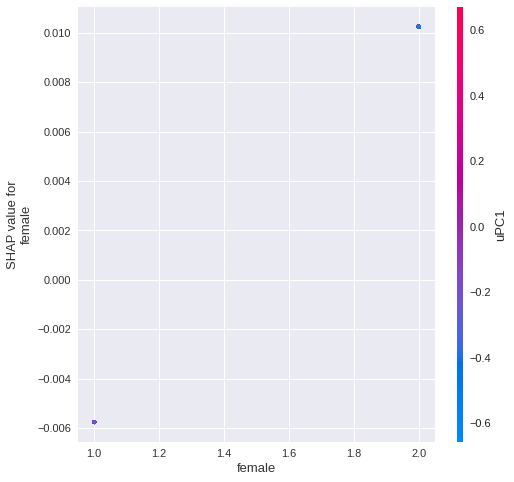

In [63]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('female', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

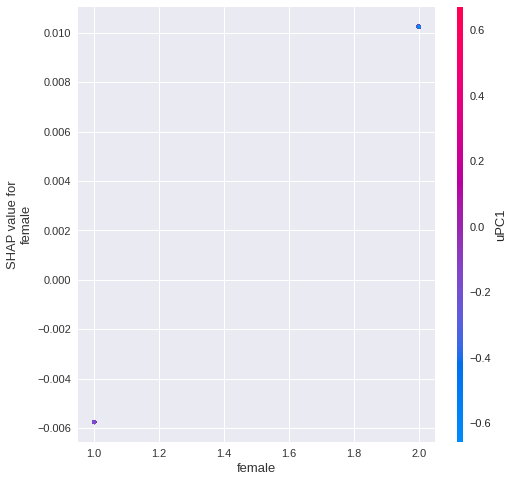

In [64]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('female', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

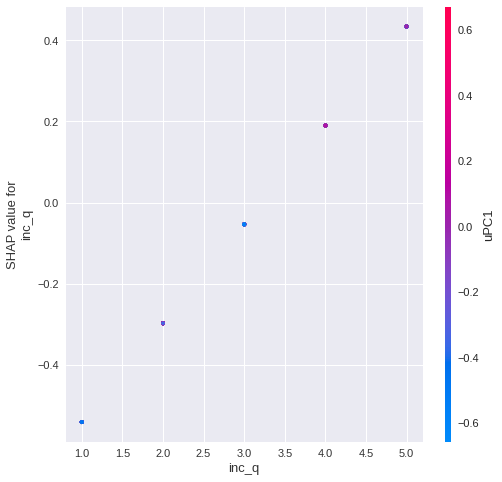

In [65]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('inc_q', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()